In [1]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('MNIST_data', one_hot=True)

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


In [0]:
import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt
import scipy.ndimage as nd

%matplotlib inline
import pylab as pl
from IPython import display

In [0]:
def var(name, shape, init=None):
    if init is None:
      init = tf.truncated_normal_initializer(stddev=(2/shape[0])**0.5)
    return tf.get_variable(name=name, shape=shape, dtype=tf.float32,
                          initializer=init)

def conv(Xin, f, strides=[1, 1, 1, 1], padding='SAME'):
    return tf.nn.conv2d(Xin, f, strides, padding)

def max_pool(Xin, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME'):
    return tf.nn.max_pool(Xin, ksize, strides, padding)

In [0]:
def ln_dirichlet(p, alpha):
    lnB = tf.lgamma(tf.reduce_sum(alpha,1,keep_dims=True)) - tf.reduce_sum(tf.lgamma(alpha),1,keep_dims=True)
    lnP = tf.reduce_sum(tf.log(p+1e-10)*(alpha-1),1,keep_dims=True)
    return lnB+lnP

def dirichlet(p, alpha):
    return tf.exp(ln_dirichlet(p, alpha))

def KL(alpha):
    beta=tf.constant(np.ones((1,K)),dtype=tf.float32)
    S_alpha = tf.reduce_sum(alpha,axis=1,keep_dims=True)
    S_beta = tf.reduce_sum(beta,axis=1,keep_dims=True)
    lnB = tf.lgamma(S_alpha) - tf.reduce_sum(tf.lgamma(alpha),axis=1,keep_dims=True)
    lnB_uni = tf.reduce_sum(tf.lgamma(beta),axis=1,keep_dims=True) - tf.lgamma(S_beta)
    
    dg0 = tf.digamma(S_alpha)
    dg1 = tf.digamma(alpha)
    
    kl = tf.reduce_sum((alpha - beta)*(dg1-dg0),axis=1,keep_dims=True) + lnB + lnB_uni
    return kl
  
def mse_loss(p, alpha): 
    S = tf.reduce_sum(alpha, axis=1, keep_dims=True) 
    E = alpha - 1
    U = K / S
    m = alpha / S
    mode = (E + 1e-7) / (S-K + 1e-6)
    A = tf.reduce_sum((p-m)**2, axis=1, keep_dims=True) 
    B = tf.reduce_sum(alpha*(S-alpha)/(S*S*(S+1)), axis=1, keep_dims=True) 
    
    maxI = tf.reduce_max((1-p) * E, axis=1, keep_dims=True)
    maxJ = tf.reduce_max(p * E, axis=1, keep_dims=True)
    
    f = tf.cast(tf.greater_equal(maxI,maxJ),tf.float32)
    annealing_coef = tf.minimum(4.0,tf.cast(global_step//annealing_step,tf.float32)*0.01)
    
    alp = E*(1-p) + 1 
    C =  annealing_coef *KL(alp)
    
    return (A + B) + C

In [0]:
lmb = 0.001 # regularization coef.
step_size = 5 # number of epochs to print intermediate results
K = 10 #number of class labels

In [6]:
g = tf.Graph()

with g.as_default():
    X = tf.placeholder(shape=[None,28*28], dtype=tf.float32)
    Y = tf.placeholder(shape=[None,10], dtype=tf.float32)
    keep_prob = tf.placeholder(dtype=tf.float32) 
    annealing_step = tf.placeholder(dtype=tf.int32) 
    
    global_step = tf.Variable(initial_value=0, name='global_step', trainable=False)
    
    Xin = tf.reshape(X, [-1, 28,28, 1])
    
    # first hidden layer - conv
    W1 = var('W1', [5,5,1,20])
    b1 = var('bias1', [20])
    out1 = max_pool(tf.nn.relu(conv(Xin, W1, strides=[1, 1, 1, 1]) + b1))
    
    # second hidden layer - conv
    W2 = var('W2', [5,5,20,50])
    b2 = var('bias2', [50])
    out2 = max_pool(tf.nn.relu(conv(out1, W2, strides=[1, 1, 1, 1]) + b2))
    
    # flatten the output
    Xflat = tf.contrib.layers.flatten(out2)
     
    W3 = var('W3', [Xflat.get_shape()[1].value, 500])
    b3 = var('bias3', [500]) 
    out3 = tf.nn.relu(tf.matmul(Xflat, W3) + b3)
    out3 = tf.nn.dropout(out3, keep_prob=keep_prob) 
    
    W4 = var('W4', [500,10])
    b4 = var('bias4',[10])
    logits = tf.matmul(out3, W4) + b4
    
    
    #------------------------------------------
    truth = tf.argmax(Y, 1) 
    evidence = tf.nn.relu(logits)
    alpha = evidence + 1
    total_evidence = tf.reduce_sum(evidence,1, keepdims=True) 
    mean = alpha/tf.reduce_sum(alpha, 1, keepdims=True)
    #--------------------------------
        
    pred = tf.argmax(logits, 1)  
         
    
    match = tf.cast(tf.equal(pred, truth), tf.float32)
    match = tf.reshape(match,(-1,1))
    acc = tf.reduce_mean(match)
    
    mean_ev = tf.reduce_mean(total_evidence)
    mean_ev_succ = tf.reduce_sum(tf.reduce_sum(evidence,1, keepdims=True)*match) / tf.reduce_sum(match+1e-20)
    mean_ev_fail = tf.reduce_sum(tf.reduce_sum(evidence,1, keepdims=True)*(1-match)) / (tf.reduce_sum(tf.abs(1-match))+1e-20) 
    
    
    l2_loss = (tf.nn.l2_loss(W3)+tf.nn.l2_loss(W4)) * lmb
    
    P = Y
    
    
    loss_dirichlet = tf.reduce_mean(mse_loss(P, alpha))
    
    loss = loss_dirichlet + l2_loss
    
    
    step = tf.train.AdamOptimizer().minimize(loss, global_step=global_step, var_list=[W1, b1, W2,b2, W3, b3, W4, b4]) 
    
    

Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead


In [0]:
sess = tf.InteractiveSession(graph=g)
tf.global_variables_initializer().run()

In [0]:
epoch_no = 0
e_ =[]
e_suc = []
e_fail = []
acc_l=[]
p_mis_l=[]
p_cor_l=[]

e_suc_train = []
e_fail_train = []
acc_l_train=[]
p_mis_l_train=[]
p_cor_l_train=[]
p_noise_entropy=[]

In [0]:
def print_func(W):
        
        #--------------------------------------------------- 
        ind = np.arange(0,len(e_), 2).tolist()
        e__ = np.array(e_)
        e_suc_ = np.array(e_suc)
        e_fail_= np.array(e_fail)
        acc_l_= np.array(acc_l)
        e_suc_train_= np.array(e_suc_train)
        e_fail_train_= np.array(e_fail_train)
        acc_l_train_ = np.array(acc_l_train)
        e_fail_train_[0]=100
        
        f, axs = pl.subplots(2, 2)
        f.set_size_inches([10,10])
        axs[0,0].plot(e__[ind], e_suc_[ind],c='r',marker='+')
        axs[0,0].plot(e__[ind], e_fail_[ind],c='k',marker='x')
        axs[0,0].set_title('Test Data')
        axs[0,0].set_xlabel('Epoch')
        axs[0,0].set_ylabel('Estimated total evidence for classification') 
        axs[0,0].legend(['Correct Clasifications','Misclasifications'])
        #axs[0,0].set_xlim([0,400])
        #axs[0,0].set_ylim([0,100])

        axs[0,1].plot(e__[ind], W/(e_suc_[ind]+W),c='r',marker='+')
        axs[0,1].plot(e__[ind], W/(e_fail_[ind]+W),c='k',marker='x')
        axs[0,1].plot(e__[ind],acc_l_[ind],c='blue',marker='*')
        axs[0,1].set_title('Test Data')
        axs[0,1].set_xlabel('Epoch')
        axs[0,1].set_ylabel('Estimated uncertainty for classification')
        axs[0,1].legend(['Correct clasifications','Misclasifications', 'Accuracy'])
        #axs[0,1].set_xlim([0,400])

        axs[1,0].plot(e__[ind], e_suc_train_[ind],c='r',marker='+')
        axs[1,0].plot(e__[ind], e_fail_train_[ind],c='k',marker='x')
        axs[1,0].set_title('Training Data')
        axs[1,0].set_xlabel('Epoch')
        axs[1,0].set_ylabel('Estimated total evidence for classification') 
        axs[1,0].legend(['Correct Clasifications','Misclasifications'])
        #axs[1,0].set_xlim([0,400])
        #axs[1,0].set_ylim([0,100])

        axs[1,1].plot(e__[ind], W/(e_suc_train_[ind]+W),c='r',marker='+')
        axs[1,1].plot(e__[ind], W/(e_fail_train_[ind]+W),c='k',marker='x')
        axs[1,1].plot(e__[ind],acc_l_train_[ind],c='blue',marker='*')
        axs[1,1].set_title('Training Data')
        axs[1,1].set_xlabel('Epoch')
        axs[1,1].set_ylabel('Estimated uncertainty for classification')
        axs[1,1].legend(['Correct Clasifications','Misclasifications', 'Accuracy'])
        #axs[1,1].set_xlim([0,400])
    
        display.clear_output(wait=True)
        display.display(pl.gcf())
        print('test acc: ', acc_)
        
        
        print('%i) p_mis:%2.4f \t p_cor: %2.4f \t noise entropy: %2.4f \n\n' % (len(acc_l), p_mis, p_cor,noise_entropy.mean()))
        
        

In [0]:
saver = tf.train.Saver()
bsize = 1000
n_batches = mnist.train.num_examples // bsize
for epoch in range(500): 
    epoch_no += 1
    tot_ev_succ = 0
    tot_ev_fail = 0
    tot_acc = 0
    tot_suc = 0.001
    tot_fail = 0.001
    for i in range(n_batches):
        data, label = mnist.train.next_batch(bsize, shuffle=True)
        feed_dict={X:data, Y:label, keep_prob:.5, annealing_step:50}
        sess.run(step,feed_dict)
        
        match_, acc_, me, mes, mef,loss_ = sess.run([match, acc,mean_ev,mean_ev_succ,mean_ev_fail,loss_dirichlet], feed_dict=feed_dict)
        
        n_succ = match_.sum()
        n_fail = (1-match_).sum()
        tot_ev_succ += mes*n_succ
        tot_ev_fail += mef*n_fail
        tot_suc += n_succ
        tot_fail += n_fail
        tot_acc +=  acc_
     
    
    if not epoch % step_size:
        
        e_suc_train.append(tot_ev_succ/(tot_suc))
        e_fail_train.append(tot_ev_fail/(tot_fail))
        acc_l_train.append(tot_acc/(i+1)) 
        
        text = '%d - %d) acc:%2.4f \t loss:%2.4f \t mean ev: %2.4f \t mean ev succ: %2.4f \t mean ev fail: %2.4f \t' 
        text += 'avg acc: %2.4f \t avg ev succ: %2.4f \t avg ev fail: %2.4f'
        print(text  %(epoch, i, acc_, loss_, me, mes, mef,tot_acc/(i+1),tot_ev_succ/(tot_suc),tot_ev_fail/(tot_fail)))
     
        acc_ , me,mes, mef, m_, p_pred_ = sess.run([acc,mean_ev,mean_ev_succ,mean_ev_fail, match, mean], 
                                       feed_dict={X:mnist.test.images,Y:mnist.test.labels, keep_prob:1.0})
        
        p_mis=np.mean(np.max(p_pred_[m_[:,0]==0],1))
        p_cor= np.mean(np.max(p_pred_[m_[:,0]==1],1))
        
        p_mis_l.append(p_mis)
        p_cor_l.append(p_cor)
        
        e_.append(epoch_no)
        e_suc.append(mes)
        e_fail.append(mef)
        acc_l.append(acc_)
        
        
        noise_p  = sess.run(mean,feed_dict={X:np.random.random(size=(1000,28*28)), Y:mnist.test.labels, keep_prob:1.} )
        noise_entropy = -np.sum(noise_p*np.log(noise_p),axis=1)
        p_noise_entropy.append(noise_entropy.mean())

0 - 54) acc:0.9330 	 loss:0.1491 	 mean ev: 65.6395 	 mean ev succ: 68.3191 	 mean ev fail: 28.3247 	avg acc: 0.7893 	 avg ev succ: 151.6805 	 avg ev fail: 362.7035
5 - 54) acc:0.9740 	 loss:0.0818 	 mean ev: 73.7481 	 mean ev succ: 75.2496 	 mean ev fail: 17.5006 	avg acc: 0.9766 	 avg ev succ: 75.6570 	 avg ev fail: 18.6769
10 - 54) acc:0.9780 	 loss:0.0793 	 mean ev: 82.8796 	 mean ev succ: 84.3475 	 mean ev fail: 17.6275 	avg acc: 0.9836 	 avg ev succ: 82.6962 	 avg ev fail: 15.1008
15 - 54) acc:0.9890 	 loss:0.0567 	 mean ev: 85.7160 	 mean ev succ: 86.5478 	 mean ev fail: 10.9313 	avg acc: 0.9858 	 avg ev succ: 87.2933 	 avg ev fail: 13.1823
20 - 54) acc:0.9800 	 loss:0.0779 	 mean ev: 87.3631 	 mean ev succ: 88.8981 	 mean ev fail: 12.1436 	avg acc: 0.9872 	 avg ev succ: 90.0706 	 avg ev fail: 10.9391
25 - 54) acc:0.9880 	 loss:0.0716 	 mean ev: 92.5414 	 mean ev succ: 93.4440 	 mean ev fail: 18.2204 	avg acc: 0.9891 	 avg ev succ: 91.4435 	 avg ev fail: 9.5046
30 - 54) acc:0.99

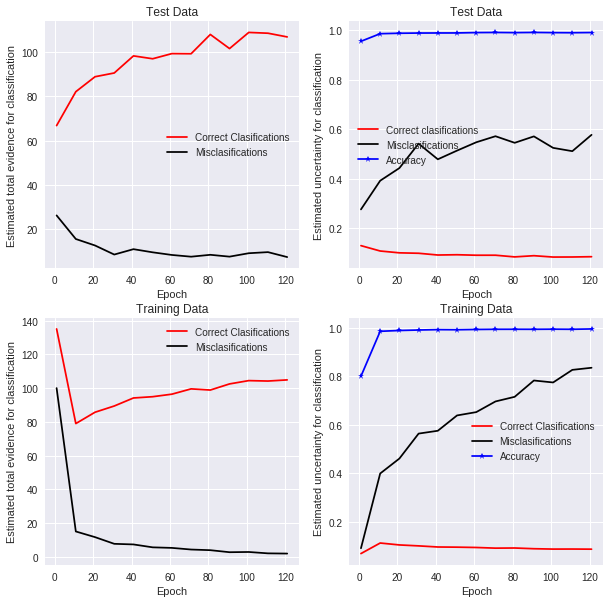

test acc:  0.992
25) p_mis:0.3129 	 p_cor: 0.8979 	 noise entropy: 2.1052 




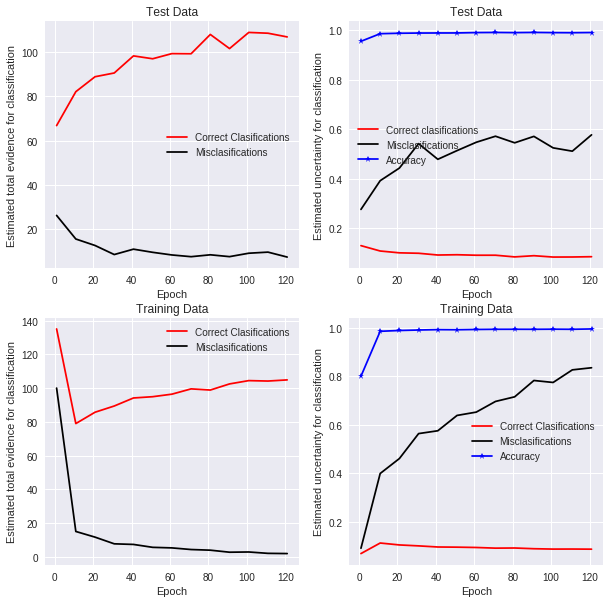

In [0]:
print_func(10)